**Load Dataset**

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [3]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d rohitsahoo/sales-forecasting
!unzip sales-forecasting.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting
License(s): GPL-2.0
  0% 0.00/480k [00:00<?, ?B/s]
100% 480k/480k [00:00<00:00, 99.2MB/s]
Archive:  sales-forecasting.zip
  inflating: train.csv               


In [4]:
df = pd.read_csv("train.csv")

# Basic information about the dataset
df.head()
#df.info()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


**Exploratory Data Analysis**


---


Distribution of Sales Amount

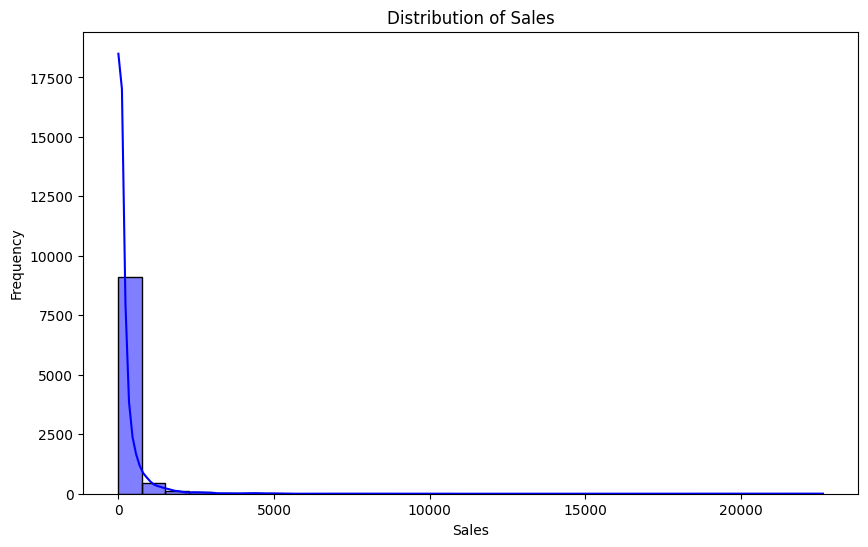

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

Monthly Sales Trend

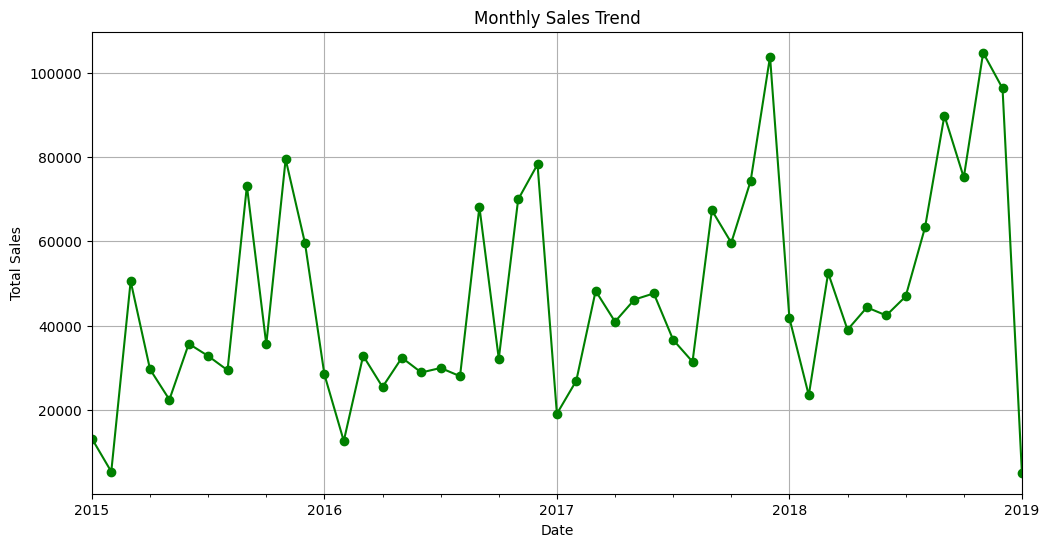

In [5]:
# Ensure the date is parsed correctly
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

# Set the Date column as the index
df.set_index('Ship Date', inplace=True)

# Resample to get monthly sales data
monthly_sales = df['Sales'].resample('M').sum()

# Plot the monthly sales trend
plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o', color='green')
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()



Total Sales by Category

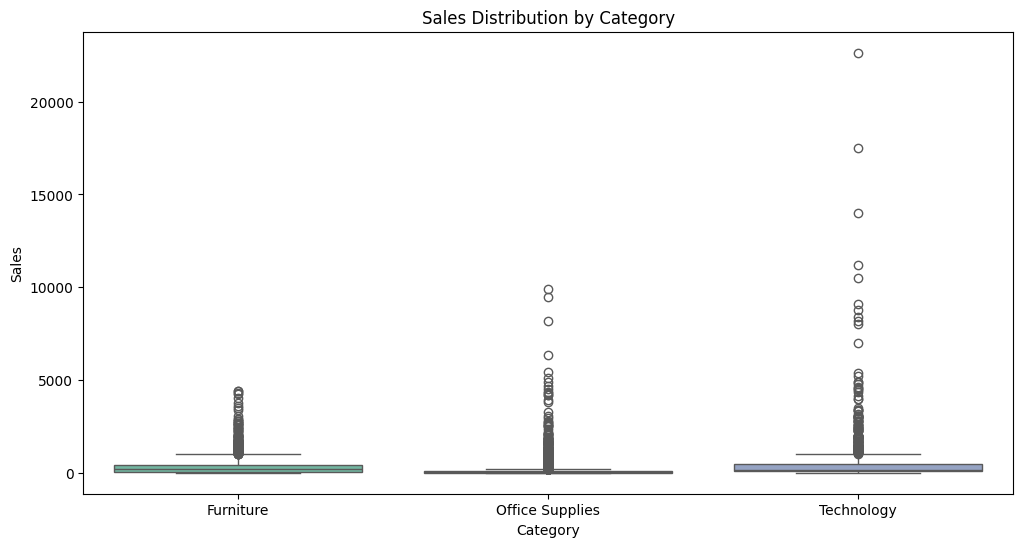

In [8]:
# Sales by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Sales', data=df, palette='Set2')
plt.title('Sales Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.show()

Average Sales by Region

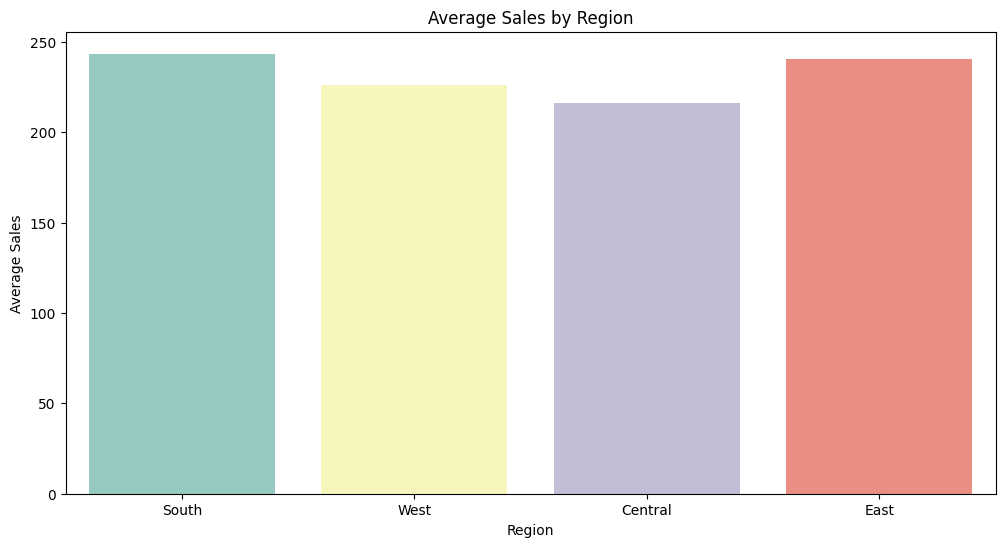

In [9]:
# Sales by region
plt.figure(figsize=(12, 6))
sns.barplot(x='Region', y='Sales', data=df, estimator=np.mean, ci=None, palette='Set3')
plt.title('Average Sales by Region')
plt.xlabel('Region')
plt.ylabel('Average Sales')
plt.show()

**Machine Learning Models**


---

Data Preprocessing

In [10]:
# Extract additional features from the Date column
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Quarter'] = df.index.quarter

# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['Category', 'Region'], drop_first=True)

# Fill missing values if any
df.fillna(0, inplace=True)

# Lag Features for Sales
df['Sales_Lag1'] = df['Sales'].shift(1)
df['Sales_Lag12'] = df['Sales'].shift(12)

# Fill missing lag features
df.fillna(0, inplace=True)


Model Training


In [11]:
# Define features and target
X = df.drop(columns=['Sales'])
y = df['Sales']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Identify features and target
X = df.drop(['Sales'], axis=1)  # Drop the target column
y = df['Sales']  # Target column

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numeric and categorical data
numeric_transformer = 'passthrough'
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # Handle unknown categories

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=42))
    ])
}

# Evaluate each model
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
    print("-" * 30)


Model: Random Forest
MAE: 168.53, RMSE: 676.88, R2: 0.31
------------------------------
Model: Gradient Boosting
MAE: 232.21, RMSE: 714.97, R2: 0.24
------------------------------


**Forecasting**

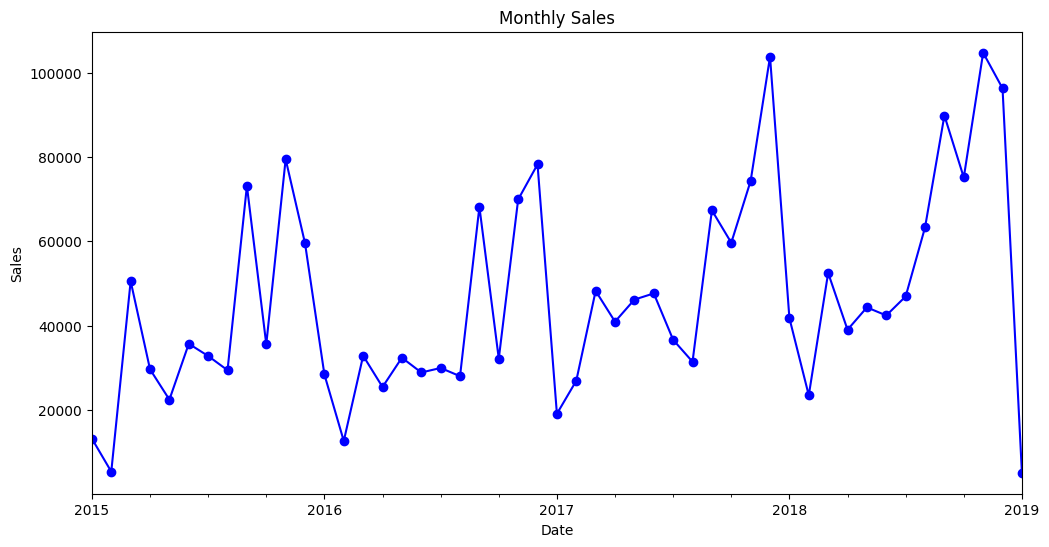

In [15]:
monthly_sales = df['Sales'].resample('M').sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o', color='blue')
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


Exponential Smoothing

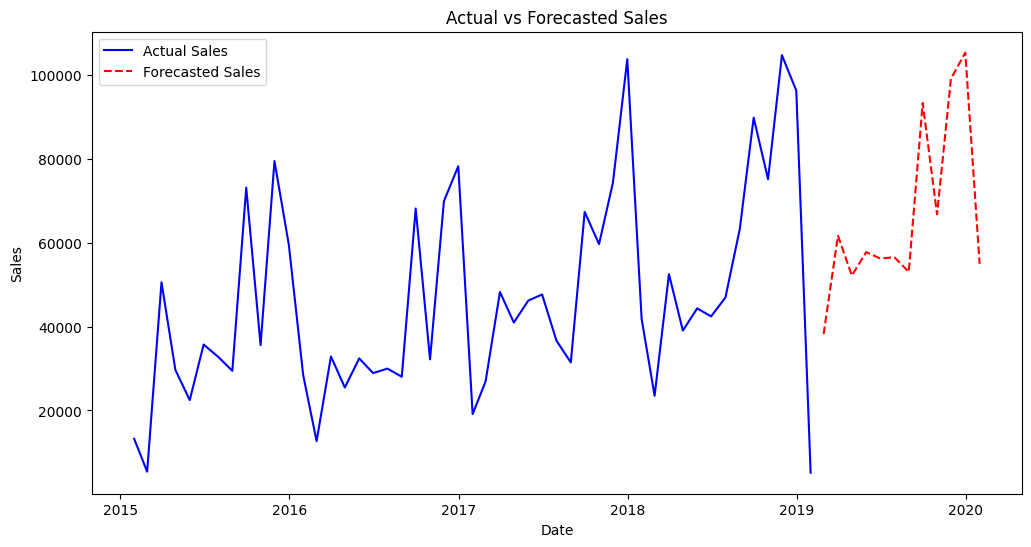

In [16]:
# Fit Exponential Smoothing model
model = ExponentialSmoothing(monthly_sales, trend='add', seasonal='add', seasonal_periods=12).fit()

# Forecast next 12 months
forecast = model.forecast(12)

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual Sales', color='blue')
plt.plot(forecast, label='Forecasted Sales', color='red', linestyle='--')
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


Evalution

In [17]:
# Compare forecast to actual for the last 12 months
actual = monthly_sales[-12:]
forecasted = forecast[:len(actual)]

mae_forecast = mean_absolute_error(actual, forecasted)
rmse_forecast = np.sqrt(mean_squared_error(actual, forecasted))

print(f"Forecasting MAE: {mae_forecast:.2f}")
print(f"Forecasting RMSE: {rmse_forecast:.2f}")


Forecasting MAE: 13361.34
Forecasting RMSE: 17593.45
